# Camera people detection

Failed experinemt that would detect people on camera and then automatically labeled the data

In [ ]:
import cv2
from dataset import *
import matplotlib.pyplot as plot

def get_background(cap):
    # we will randomly select 50 frames for the calculating the median
    frame_indices = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=50)

    # we will store the frames in array
    frames = []
    for idx in frame_indices:
        # set the frame id to read that particular frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        frames.append(frame)

    # calculate the median
    median_frame = np.median(frames, axis=0).astype(np.uint8)
    return cv2.cvtColor(median_frame, cv2.COLOR_BGR2GRAY)

def count_n_of_people(frame, median_frame):
    out = 0
    frame = frame[100:,:]
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(gray, median_frame)
    ret, thres = cv2.threshold(frame_diff, 50, 255, cv2.THRESH_BINARY)
    thres = cv2.morphologyEx(thres, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (125,125)))
    dilate_frame = cv2.dilate(thres, None, iterations=2)
    # find the contours around the white segmented areas
    contours, hierarchy = cv2.findContours(dilate_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # draw the contours, not strictly necessary
    for j, cnt in enumerate(contours):
        if cv2.contourArea(cnt) < 4000:
            continue
        (x, y, w, h) = cv2.boundingRect(cnt)
        if w/h > 3.5:
            continue
        out+=1
        # draw the bounding boxes
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.drawContours(frame, contours, j, (0, 0, 255), 3)
    # plot.imshow(frame)
    # plot.show()
    
    return out

4798 7207.0


C:\Users\janez\AppData\Local\Temp\ipykernel_1572\701363398.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, f in tqdm(enumerate(data), total=nOfDataFrames):


  0%|          | 0/4798 [00:00<?, ?it/s]

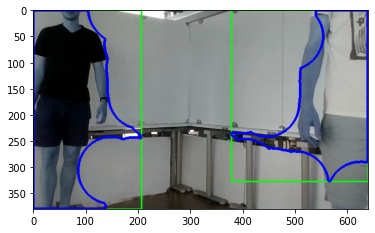

1056 1591.0


  0%|          | 0/1056 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import json
from tqdm import tqdm_notebook as tqdm

recrodings = [{"title": "recording_2022_05_26_11_08_08"},
            {"title": "recording_2022_05_26_11_06_53"}
]
for recording in recrodings:
    file_name = f'../../recordings/{recording["title"]}/RadarIfxAvian_00/radar.npy'
    video_file = f'../../recordings/{recording["title"]}/CamOpenCV_00/rgb.mp4'
    data = np.load(file_name)
    cap = cv2.VideoCapture(video_file)
    
    nOfDataFrames = data.shape[0]
    nOfVideoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    print(nOfDataFrames, nOfVideoFrames)
    def video_frame_number(data_frame_number):
        k = nOfVideoFrames/nOfDataFrames
        return int(data_frame_number * k)

    median_frame = get_background(cap)[100:,:]


    out = []
    # iterate frames, skpi first 60 - the camera needs some adjustement
    for idx, f in tqdm(enumerate(data), total=nOfDataFrames): 
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_frame_number(idx))
        ret, frame = cap.read()
        out.append(count_n_of_people(frame, median_frame))
    json_string = json.dumps(out)

    with open(f'../../recordings/{recording["title"]}/RadarIfxAvian_00/labels.json', 'w') as outfile:
        outfile.write(json_string)
